In [1]:
import pandas as pd 
import wandb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
api = wandb.Api()

In [28]:
# Project is specified by <entity/project-name>
training_runs = api.runs("amar-research/safetyh",
                 filters={"tags" : "corrected-cycle"}
                )

history_dataframes = []

for run in tqdm(training_runs, desc="Processing Training Runs"):
    ego_version = run.config['ego_version']
    npc_version = run.config['npc_version']
    history = run.scan_history()
    episodes = history.max_step
    tags = run.tags
    sampling = run.config['model_sampling']
        

    history_dataframes.append((run.history(samples=episodes, x_axis="_step", pandas=(True), stream="default"),run.config))

Processing Training Runs: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]


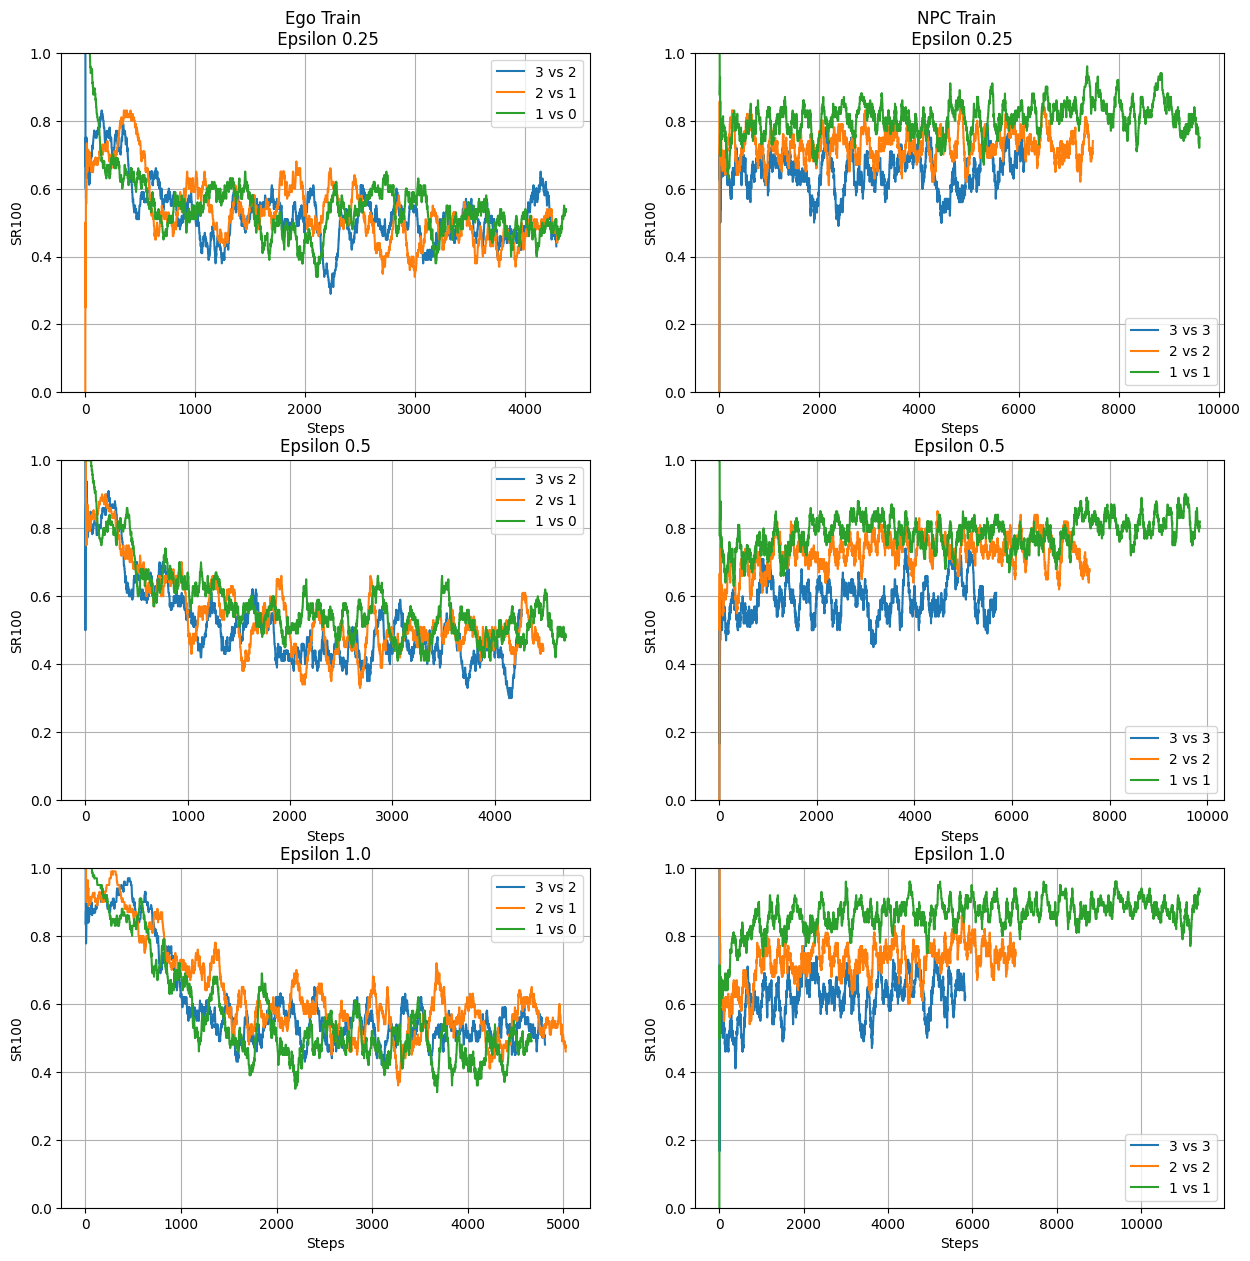

In [38]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
# Plot SR100 from index 0 of History Dataframes
for history_df, config in history_dataframes:
    if config['train_ego']:
        if config['eps_start'] == 0.25:
            ax[0,0].plot(history_df["_step"], history_df["rollout/sr100"], label=f"{config['ego_version']} vs {config['npc_version']}")
        elif config['eps_start'] == 0.5:
            ax[1,0].plot(history_df["_step"], history_df["rollout/sr100"], label=f"{config['ego_version']} vs {config['npc_version']}")
        elif config['eps_start'] == 1.0:
            ax[2,0].plot(history_df["_step"], history_df["rollout/sr100"], label=f"{config['ego_version']} vs {config['npc_version']}")
    else:
        if config['eps_start'] == 0.25:
            ax[0,1].plot(history_df["_step"], history_df["rollout/sr100"], label=f"{config['ego_version']} vs {config['npc_version']}")
        elif config['eps_start'] == 0.5:
            ax[1,1].plot(history_df["_step"], history_df["rollout/sr100"], label=f"{config['ego_version']} vs {config['npc_version']}")
        elif config['eps_start'] == 1.0:
            ax[2,1].plot(history_df["_step"], history_df["rollout/sr100"], label=f"{config['ego_version']} vs {config['npc_version']}")

ax[0,0].set_title("Epsilon 0.25")
ax[0,0].set_xlabel("Steps")
ax[0,0].set_ylabel("SR100")
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_ylim(0,1)
ax[1,0].set_title("Epsilon 0.5")
ax[1,0].set_xlabel("Steps")
ax[1,0].set_ylabel("SR100")
ax[1,0].legend()
ax[1,0].grid()
ax[1,0].set_ylim(0,1)
ax[2,0].set_title("Epsilon 1.0")
ax[2,0].set_xlabel("Steps")
ax[2,0].set_ylabel("SR100")
ax[2,0].legend()
ax[2,0].grid()
ax[2,0].set_ylim(0,1)
ax[0,1].set_title("Epsilon 0.25")
ax[0,1].set_xlabel("Steps")
ax[0,1].set_ylabel("SR100")
ax[0,1].legend()
ax[0,1].grid()
ax[0,1].set_ylim(0,1)
ax[1,1].set_title("Epsilon 0.5")
ax[1,1].set_xlabel("Steps")
ax[1,1].set_ylabel("SR100")
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_ylim(0,1)
ax[2,1].set_title("Epsilon 1.0")
ax[2,1].set_xlabel("Steps")
ax[2,1].set_ylabel("SR100")
ax[2,1].legend()
ax[2,1].grid()
ax[2,1].set_ylim(0,1)

# Set Title for Left and Right Column
ax[0,0].set_title("Ego Train \n Epsilon 0.25")
ax[0,1].set_title("NPC Train \n Epsilon 0.25")
plt.show()